In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType

spark=SparkSession.builder.appName('FordGoBike').getOrCreate()



23/05/09 08:52:31 WARN Utils: Your hostname, codespaces-3e9f4e resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
23/05/09 08:52:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/09 08:52:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path="/workspaces/develhope-Data5-Team3/Data/week_2"
df=spark.read.csv(path,header=True, inferSchema=True)

##TASK_1 - Calculate the number of trips for each start station list top 10 and find the ratio of using as male or female - FAIZA

In [3]:
df.select(F.count(F.when(F.col('member_gender')=='Male',True)), F.count(F.when(F.col('member_gender')=='Female',True))).show()

+-----------------------------------------------------+-------------------------------------------------------+
|count(CASE WHEN (member_gender = Male) THEN true END)|count(CASE WHEN (member_gender = Female) THEN true END)|
+-----------------------------------------------------+-------------------------------------------------------+
|                                               348318|                                                  98621|
+-----------------------------------------------------+-------------------------------------------------------+



In [4]:
df3_1 = df.withColumn('F', F.when(F.col('member_gender') == 'Female', 1).otherwise(0)).withColumn('M', F.when(F.col('member_gender') == 'Male', 1).otherwise(0))

df3_1.select('F', 'M','member_gender').show(10)

+---+---+-------------+
|  F|  M|member_gender|
+---+---+-------------+
|  0|  1|         Male|
|  1|  0|       Female|
|  0|  0|         null|
|  0|  0|         null|
|  1|  0|       Female|
|  0|  0|         null|
|  1|  0|       Female|
|  0|  0|         null|
|  0|  0|         null|
|  0|  0|         null|
+---+---+-------------+
only showing top 10 rows



In [5]:
from pyspark.sql.functions import desc

df3_1_1 = df3_1.groupBy('start_station_id').agg({'start_station_id':'count', 'F':'sum', 'M': 'sum'}).orderBy(desc('count(start_station_id)')).limit(10)

df3_1_2 = df3_1_1.withColumn('ratio', df3_1_1[1]/df3_1_1[2])
df3_1_2.show()

+----------------+-----------------------+------+------+-----------------+
|start_station_id|count(start_station_id)|sum(F)|sum(M)|            ratio|
+----------------+-----------------------+------+------+-----------------+
|              15|                  15187|  2819|  8586|5.387371408300816|
|               6|                  13664|  1938|  7444|7.050567595459237|
|              30|                  12546|  2035|  9813|6.165110565110565|
|              67|                  12055|  2105|  9409|5.726840855106889|
|              58|                  11960|  1870|  9005| 6.39572192513369|
|              21|                  11334|  1631|  8367|6.949110974862048|
|              81|                  10956|  2302|  7773|4.759339704604692|
|               3|                  10142|  1768|  6070|5.736425339366516|
|              22|                   9926|  1980|  7512|5.013131313131313|
|              16|                   9347|  1740|  6532| 5.37183908045977|
+----------------+-------

In [6]:
df3_1_1 = df.groupBy('start_station_id').count().orderBy(desc('count')).show(10)

+----------------+-----+
|start_station_id|count|
+----------------+-----+
|              15|15187|
|               6|13664|
|              30|12546|
|              67|12055|
|              58|11960|
|              21|11334|
|              81|10956|
|               3|10142|
|              22| 9926|
|              16| 9347|
+----------------+-----+
only showing top 10 rows



##TASK_2 - Make a comparison to find the percentage of usage for customer and subscriber - UROS

In [7]:
df.select('user_type').distinct().show()

+----------+
| user_type|
+----------+
|Subscriber|
|  Customer|
+----------+



In [8]:
df.groupBy('user_type').agg(F.round(F.count('user_type')/df.count()*100, 2).alias('User Percentage')).show()

+----------+---------------+
| user_type|User Percentage|
+----------+---------------+
|Subscriber|          78.74|
|  Customer|          21.26|
+----------+---------------+



##TASK_3 - Calculate the age of all users and show the relation between the distance and the age - ONUR

In [9]:
df3_3=df.where(F.col('haversine_distance')!=0) #cleaning zero distance entries

In [10]:
df3_3=df3_3.withColumn('age',2017-F.col('member_birth_year')).withColumn('age',F.col('age').cast('int'))

In [11]:
df3_3=df3_3.where((F.col('age')>18) & (F.col('age')<=100)) #cleaning outlier values(age=100+)
df3_3=df3_3.dropna(how='all',subset=['age'])


In [12]:
#Age groupped haversine distance mean 

df3_3=df3_3.withColumn('age_group', F.when(((F.col('age')>=18) & (F.col('age')<35)),'18 to 35')\
                      .otherwise(F.when((F.col('age')>=35)&(F.col('age')<50),'35 to 50')\
                      .otherwise(F.when((F.col('age')>=50)&(F.col('age')<65),'50 to 65')\
                                 .otherwise(F.when((F.col('age')>=65)&(F.col('age')<=100),'65 to 100').otherwise('non-groupped')))))

df3_3_ag=df3_3.groupby('age_group').agg(F.mean('haversine_distance').alias('Age Group/Distance')).sort(F.col('age_group'))

In [13]:
df3_3_ag=df3_3.groupby('age_group').agg(F.sum('haversine_distance').alias('Age Group/Distance')).sort(F.col('age_group'))

In [14]:
df3_3.where(F.col('age_group')=='non-groupped').show()

+----------+-----------+--------+---------+----------------+------------------+----------------------+-----------------------+--------------+----------------+--------------------+---------------------+-------+---------+-----------------+-------------+------+------------------+---------------+---------------+---------+---+---------+
|start_time|start_am_pm|end_time|end_am_pm|start_station_id|start_station_name|start_station_latitude|start_station_longitude|end_station_id|end_station_name|end_station_latitude|end_station_longitude|bike_id|user_type|member_birth_year|member_gender|pyment|haversine_distance|Diff_in_seconds|Diff_in_minutes|Trip_cost|age|age_group|
+----------+-----------+--------+---------+----------------+------------------+----------------------+-----------------------+--------------+----------------+--------------------+---------------------+-------+---------+-----------------+-------------+------+------------------+---------------+---------------+---------+---+---------

In [15]:
df3_3.write.option("header",True).mode('overwrite').csv('/workspaces/develhope-Data5-Team3/Data/week_3')

In [7]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [36]:
pd=df3_3_ag.toPandas()

In [52]:
pd.head()

,age_group,Age Group/Distance
0,18 to 35,1.658157
1,35 to 50,1.625969
2,50 to 65,1.582817
3,65 to 95,1.543864


Text(-35.30555555555556, 0.5, 'Age Group')

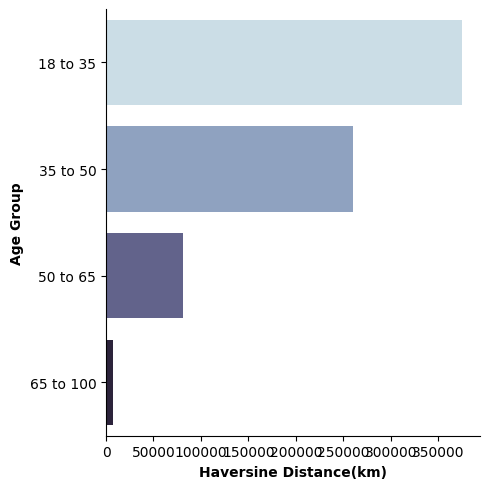

In [37]:
# sn.barplot(x= pd["age_group"], y= pd['Age Group/Distance'], data=pd)
sn.catplot(data=pd, x='Age Group/Distance', y="age_group", errorbar=("pi", 95), kind="bar", palette="ch:s=.25,rot=-.25")
plt.xlabel('Haversine Distance(km)', weight = 'bold')
plt.ylabel('Age Group', weight = 'bold')

In [30]:
df3_3_ng=df3_3.groupBy('age').agg(F.mean('haversine_distance').alias('Avg_Distance')).sort(F.col('Avg_Distance'))

In [38]:
df3_3_ng=df3_3.groupBy('age').agg(F.sum('haversine_distance').alias('Avg_Distance')).sort(F.col('Avg_Distance'))

In [40]:
df3_3_ng.show(100)

+---+------------------+
|age|      Avg_Distance|
+---+------------------+
| 89| 36.53156664798689|
| 79|38.671030426176124|
| 78| 49.26734083030295|
| 83| 58.41582255711995|
| 77|58.667612251182845|
| 84|  73.6153581656906|
| 71| 80.30003968419487|
| 76| 88.16493578425374|
| 82| 89.47172514058899|
| 75| 93.20189566516089|
| 93|127.92883646583624|
| 74|188.87010017496175|
| 73|401.85417696658016|
| 72| 437.3998457422568|
| 69| 627.3104126554956|
| 67| 665.8831504570281|
| 70| 735.5366946431337|
| 68| 756.3483006790545|
| 64| 816.6592475741351|
| 66|1110.0203390673234|
| 62|1498.2041918902669|
| 65|1887.6130548657302|
| 19| 2115.202204432652|
| 60|2366.4545296831375|
| 20| 2682.433884045998|
| 63|2945.3063302177784|
| 21|3740.5675523581267|
| 58|3893.6074565007216|
| 57|3911.3156745228043|
| 61|4342.0049700683585|
| 59| 4555.075625512814|
| 56| 5207.482838476511|
| 51| 5657.344030797031|
| 55| 5704.853738255917|
| 53| 7858.155927263337|
| 54| 8693.011520743534|
| 48|10601.141374791605|


Text(0, 0.5, 'Haversine Distance(km)')

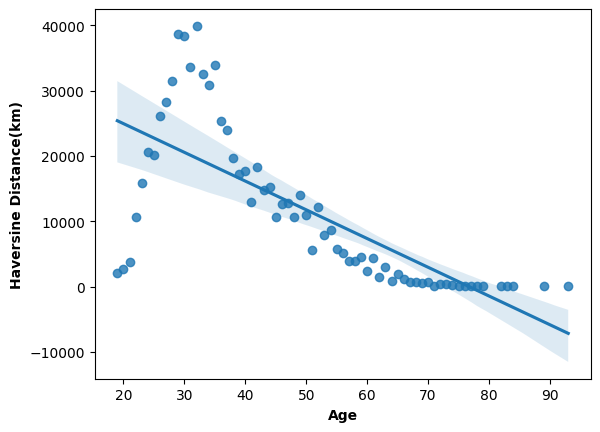

In [39]:
df2=df3_3_ng.toPandas()

sn.regplot(x= "age", y= "Avg_Distance", data=df2)
plt.xlabel('Age', weight = 'bold')
plt.ylabel('Haversine Distance(km)', weight = 'bold')